In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import ipaddress
import random
import spacy

from gensim.models import Word2Vec
from sklearn.metrics.pairwise import cosine_similarity
 
from read_pcaps import pcap_to_dataframe

# Load data

In [2]:
mirai_pcap = "data/mirai.pcap"
mirai_pkl = "data/mirai.pkl"

In [3]:
# first time you run this, you should create your own pkl
# for security reasons we do not recommend to use untrusted pkl files
READ_FROM_PKL = True

In [4]:
if READ_FROM_PKL:
    mirai_df = pd.read_pickle(mirai_pkl)
else:
    mirai_df = pcap_to_dataframe(mirai_pcap)
    # save to pkl since dataframe conversion takes a long time
    mirai_df.to_pickle(mirai_pkl)

In [5]:
mirai_df.sample(n=10)

,Timestamp,Source IP,Destination IP,Source Port,Destination Port,Payload,Packet Length,Protocol
392526,1540452015.915767,None,None,NaN,NaN,ARP who has 192.168.2.128 says 192.168.2.110 /...,60,NaN
131356,1540450918.742482,None,None,NaN,NaN,ARP who has 192.168.2.15 says 192.168.2.110 / ...,60,NaN
220642,1540451320.846589,None,None,NaN,NaN,ARP who has 192.168.2.119 says 192.168.2.110 /...,60,NaN
416260,1540452112.222022,None,None,NaN,NaN,ARP who has 192.168.2.43 says 192.168.2.110 / ...,60,NaN
62907,1540448685.298454,192.168.2.108,122.226.84.253,32761.0,10240.0,Raw,48,17.0
28771,1540447431.273852,None,None,NaN,NaN,Raw,60,NaN
627114,1540452966.594296,None,None,NaN,NaN,ARP who has 192.168.2.59 says 192.168.2.110 / ...,60,NaN
653637,1540453073.737209,None,None,NaN,NaN,ARP who has 192.168.2.162 says 192.168.2.110 /...,60,NaN
153380,1540451024.988137,None,None,NaN,NaN,ARP who has 192.168.2.176 says 192.168.2.110 /...,60,NaN
523643,1540452547.19157,None,None,NaN,NaN,ARP who has 192.168.2.10 says 192.168.2.110 / ...,60,NaN


In [6]:
mirai_df.shape

(764137, 8)

In [7]:
mirai_df_no_arp = mirai_df.dropna(subset=["Source IP", "Destination IP", "Source Port", "Destination Port"])

In [8]:
mirai_df_no_arp.sample(n=10)

,Timestamp,Source IP,Destination IP,Source Port,Destination Port,Payload,Packet Length,Protocol
672025,1540453147.567924,192.168.2.103,192.168.2.110,23.0,41313.0,Raw,34,6.0
51766,1540448282.922025,192.168.2.115,192.168.2.1,3754.0,53.0,"DNS Qry ""b'xmpp.samsungsmartcam.com.'""",50,17.0
408363,1540452080.185128,192.168.2.113,114.215.137.159,50861.0,10240.0,Raw,48,17.0
344696,1540451822.186665,192.168.2.109,119.29.29.29,51652.0,80.0,,40,6.0
25501,1540447309.106724,192.168.2.115,192.168.2.1,3126.0,53.0,"DNS Qry ""b'pool.ntp.org.'""",38,17.0
18515,1540447049.566228,192.168.2.1,192.168.2.115,53.0,2949.0,DNS Ans,83,17.0
55850,1540448436.48303,192.168.2.108,52.25.66.250,14595.0,8280.0,Padding,26,6.0
540752,1540452616.805105,192.168.2.101,192.168.2.110,23.0,21897.0,Padding,26,6.0
3355,1540446500.728891,192.168.2.108,52.25.66.250,13561.0,8280.0,Padding,26,6.0
313739,1540451697.046043,192.168.2.108,52.25.66.250,38551.0,8280.0,Padding,26,6.0


In [9]:
mirai_df_no_arp.shape

(154090, 8)

# Numerical features

## Cumulative

In [10]:
mirai_features_df = mirai_df
mirai_features_df["src_ip_total_bytes"] = mirai_df.groupby("Source IP")[
    "Packet Length"
].cumsum()

In [11]:
mirai_features_df = mirai_df
mirai_features_df["dst_ip_total_bytes"] = mirai_df.groupby("Destination IP")[
    "Packet Length"
].cumsum()

In [12]:
mirai_features_df.sample(n=10)

,Timestamp,Source IP,Destination IP,Source Port,Destination Port,Payload,Packet Length,Protocol,src_ip_total_bytes,dst_ip_total_bytes
6317,1540446602.02926,192.168.2.109,114.114.114.114,45632.0,53.0,"DNS Qry ""b'user2.ipcam.so.'""",40,17.0,7893.0,4612.0
54369,1540448380.549113,192.168.2.113,46.137.188.54,55168.0,80.0,,40,6.0,449281.0,174640.0
486625,1540452396.690337,None,None,NaN,NaN,ARP who has 192.168.2.11 says 192.168.2.110 / ...,60,NaN,NaN,NaN
431138,1540452172.518559,192.168.2.1,192.168.2.110,23.0,21897.0,Padding,26,6.0,1980500.0,591464.0
558941,1540452690.488003,None,None,NaN,NaN,ARP who has 192.168.2.36 says 192.168.2.110 / ...,60,NaN,NaN,NaN
210266,1540451278.661415,None,None,NaN,NaN,ARP who has 192.168.2.68 says 192.168.2.110 / ...,60,NaN,NaN,NaN
338088,1540451794.978523,None,None,NaN,NaN,ARP who has 192.168.2.251 says 192.168.2.110 /...,60,NaN,NaN,NaN
526602,1540452558.941703,None,None,NaN,NaN,ARP who has 192.168.2.235 says 192.168.2.110 /...,60,NaN,NaN,NaN
450088,1540452249.250417,None,None,NaN,NaN,ARP who has 192.168.2.128 says 192.168.2.110 /...,60,NaN,NaN,NaN
535711,1540452596.01839,None,None,NaN,NaN,ARP who has 192.168.2.191 says 192.168.2.110 /...,60,NaN,NaN,NaN


## Numerical conversions

In [13]:
def ip_to_numeric(ip):
    try:
        ip_obj = ipaddress.ip_interface(ip)
        ip = int(ip_obj.network.network_address)
    except ValueError:
        ip = 0

    return ip

In [14]:
def generate_random_ips(num_ips):
    ips = []

    # Define a list of public IP ranges and private IP ranges
    public_ranges = [
        ipaddress.IPv4Network("8.8.8.0/24"),
        ipaddress.IPv4Network("203.0.113.0/24"),
        ipaddress.IPv4Network("42.42.0.0/16"),
    ]
    private_ranges = [
        ipaddress.IPv4Network("192.168.1.0/24"),
        ipaddress.IPv4Network("10.0.0.0/8"),
        ipaddress.IPv4Network("172.16.0.0/12"),
    ]

    # Add at least two IP addresses from the same private subnet
    private_subnet = random.choice(private_ranges)
    ips.append(str(private_subnet.network_address))
    ips.append(str(private_subnet.network_address + 1))

    # Generate the remaining random IP addresses
    for _ in range(num_ips - 2):
        if random.choice([True, False]):
            # Choose a random public IP
            ip = str(
                random.choice(public_ranges).network_address + random.randint(0, 255)
            )
        else:
            # Choose a random private IP
            ip = str(
                random.choice(private_ranges).network_address + random.randint(0, 255)
            )

        ips.append(ip)

    return ips


# Generate a list of 100 random IPs
random_ips = generate_random_ips(10)

In [15]:
for ip in random_ips:
    print(f"{ip} -> {ip_to_numeric(ip)}")

192.168.1.0 -> 3232235776
192.168.1.1 -> 3232235777
203.0.113.99 -> 3405803875
192.168.1.128 -> 3232235904
192.168.1.176 -> 3232235952
192.168.1.222 -> 3232235998
42.42.0.55 -> 707395639
8.8.8.47 -> 134744111
8.8.8.16 -> 134744080
8.8.8.65 -> 134744129


In [16]:
mirai_features_df["Numeric Source IP"] = mirai_features_df["Source IP"].apply(
    ip_to_numeric
)

mirai_features_df["Numeric Destination IP"] = mirai_features_df["Destination IP"].apply(
    ip_to_numeric
)

In [17]:
# remove non-numeric IPs
mirai_features_df.pop("Source IP")
mirai_features_df.pop("Destination IP")

0           52.24.43.67
1          52.25.66.250
2         192.168.2.108
3         192.168.2.108
4                  None
              ...      
764132             None
764133             None
764134             None
764135             None
764136      192.168.2.1
Name: Destination IP, Length: 764137, dtype: object

# Categorical features

## One hot encoding

In [18]:
network_protocols = {
    1: "ICMP",
    6: "TCP",
    17: "UDP",
    23: "Telnet",
    41: "IPv6_encapsulation",
    47: "GRE",
    50: "ESP",
    51: "AH",
    53: "DNS",
    58: "ICMPv6",
    89: "OSPF",
    132: "SCTP",
    135: "SCTP",
    136: "UDPLite",
    137: "NETBIOS-NS",
    138: "NETBIOS-DGM",
    139: "NETBIOS-SSN",
    143: "IMAP",
    161: "SNMP",
    162: "SNMP_trap",
    443: "HTTPS",
    514: "Syslog",
    636: "LDAPS",
    989: "FTPS",
    993: "IMAPS",
    995: "POP3S",
    1080: "SOCKS_proxy",
    # Add more protocols as needed
}

In [19]:
def one_hot_port(port, df):
    new_df = pd.DataFrame()
    for protocol_port, protocol_name in network_protocols.items():
        new_df[protocol_name] = df[port].apply(
            lambda port: 1 if port == protocol_port else 0
        )
    return new_df

In [20]:
mirai_protocol_one_hot = one_hot_port("Destination Port", mirai_df)
mirai_features_df = pd.concat([mirai_features_df, mirai_protocol_one_hot], axis=1)

## Frequency encoding

In [21]:
frequency_encoding = (
    mirai_df["Destination Port"].value_counts(normalize=True).to_dict()
)

In [22]:
frequency_encoding

{10240.0: 0.4061232568250693,
 53.0: 0.2164035275566025,
 80.0: 0.11449633681806089,
 23.0: 0.061427245767386326,
 21897.0: 0.04645005548309226,
 8280.0: 0.04079142899786504,
 443.0: 0.019921999208311433,
 8000.0: 0.01927307415266611,
 21047.0: 0.010642370912583306,
 8080.0: 0.010253015879196112,
 1900.0: 0.006826691585388804,
 32100.0: 0.004535986138960811,
 50364.0: 0.00240751195644415,
 2323.0: 0.002018156923056956,
 57206.0: 0.0018429471580327188,
 51009.0: 0.0015574201335487765,
 123.0: 0.0012329576057261147,
 46734.0: 0.0009474305812421723,
 68.0: 0.00088253807567764,
 52777.0: 0.0006229680534195106,
 41313.0: 0.0002920162750403956,
 9000.0: 0.00026605927281458263,
 67.0: 0.00017520976502423735,
 5353.0: 0.00017520976502423735,
 8629.0: 0.00014925276279842441,
 138.0: 0.00011680651001615823,
 5355.0: 0.00010382800890325176,
 137.0: 9.733875834679853e-05,
 41291.0: 4.5424753895172646e-05,
 41274.0: 3.893550333871941e-05,
 41282.0: 3.893550333871941e-05,
 2997.0: 1.9467751669359705

In [23]:
mirai_features_df["dst_port_freq_encoded"] = mirai_df["Destination Port"].map(
    frequency_encoding
)

# Embeddings

In [24]:
# TODO: use conversations, not payload?

In [25]:
# Tokenize the payload column to individual words
mirai_tokenized_payloads = mirai_df["Payload"].apply(lambda x: x.lower().split())

mirai_tokenized_payloads

0                                                 [padding]
1                                                 [padding]
2                                    [iperror, /, tcperror]
3                                    [iperror, /, tcperror]
4         [arp, who, has, 192.168.2.106, says, 192.168.2...
                                ...                        
764132    [arp, who, has, 192.168.2.165, says, 192.168.2...
764133    [arp, who, has, 192.168.2.166, says, 192.168.2...
764134    [arp, who, has, 192.168.2.167, says, 192.168.2...
764135    [arp, who, has, 192.168.2.168, says, 192.168.2...
764136    [dns, qry, "b'north-america.pool.ntp.org.speed...
Name: Payload, Length: 764137, dtype: object

In [26]:
# Train Word2Vec model on tokenized payloads
mirai_word2vec_model = Word2Vec(
    sentences=mirai_tokenized_payloads,
    vector_size=100,
    window=5,
    min_count=1,
    workers=4,
)

In [27]:
# Function to calculate the average word embedding for a sentence
def average_word_embedding(sentence, model):
    vectors = [model.wv[word] for word in sentence if word in model.wv]
    # fix size of embeddings if it is variable
    if vectors:
        return np.mean(vectors, axis=0)
    else:
        return np.zeros(model.vector_size)

In [28]:
# Apply the average_word_embedding function to create a new column 'payload_embedding'
mirai_features_df["payload_embedding"] = mirai_tokenized_payloads.apply(
    lambda x: average_word_embedding(x, mirai_word2vec_model)
)

# Display the resulting DataFrame
mirai_features_df

,Timestamp,Source Port,Destination Port,Payload,Packet Length,Protocol,src_ip_total_bytes,dst_ip_total_bytes,Numeric Source IP,Numeric Destination IP,...,SNMP_trap,HTTPS,Syslog,LDAPS,FTPS,IMAPS,POP3S,SOCKS_proxy,dst_port_freq_encoded,payload_embedding
0,1540446382.933899,21074.0,80.0,Padding,26,6.0,26.0,26.0,3232236140,873999171,...,0,0,0,0,0,0,0,0,0.114496,"[-0.8358802, 1.3088597, 0.42671788, -0.1464681..."
1,1540446382.933904,20532.0,8280.0,Padding,26,6.0,52.0,26.0,3232236140,874070778,...,0,0,0,0,0,0,0,0,0.040791,"[-0.8358802, 1.3088597, 0.42671788, -0.1464681..."
2,1540446382.934426,NaN,NaN,IPerror / TCPerror,52,1.0,52.0,52.0,3232236033,3232236140,...,0,0,0,0,0,0,0,0,NaN,"[-0.19487727, 0.4604633, 0.5672391, 0.614552, ..."
3,1540446382.934636,NaN,NaN,IPerror / TCPerror,52,1.0,104.0,104.0,3232236033,3232236140,...,0,0,0,0,0,0,0,0,NaN,"[-0.19487727, 0.4604633, 0.5672391, 0.614552, ..."
4,1540446383.291054,NaN,NaN,ARP who has 192.168.2.106 says 192.168.2.109 /...,60,NaN,NaN,NaN,0,0,...,0,0,0,0,0,0,0,0,NaN,"[-0.45246044, 0.57912046, -0.41085052, 0.51005..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
764132,1540453519.837515,NaN,NaN,ARP who has 192.168.2.165 says 192.168.2.110 /...,60,NaN,NaN,NaN,0,0,...,0,0,0,0,0,0,0,0,NaN,"[-0.4131844, 0.3540406, -0.41491902, 0.4073574..."
764133,1540453519.839396,NaN,NaN,ARP who has 192.168.2.166 says 192.168.2.110 /...,60,NaN,NaN,NaN,0,0,...,0,0,0,0,0,0,0,0,NaN,"[-0.40407044, 0.3523604, -0.411628, 0.3956715,..."
764134,1540453519.840611,NaN,NaN,ARP who has 192.168.2.167 says 192.168.2.110 /...,60,NaN,NaN,NaN,0,0,...,0,0,0,0,0,0,0,0,NaN,"[-0.40471518, 0.35778496, -0.41598123, 0.40375..."
764135,1540453519.842369,NaN,NaN,ARP who has 192.168.2.168 says 192.168.2.110 /...,60,NaN,NaN,NaN,0,0,...,0,0,0,0,0,0,0,0,NaN,"[-0.4000873, 0.3534275, -0.40535128, 0.3988025..."


In [29]:
# eliminate payload and keep only numerical features
mirai_features_df.pop("Payload")

0                                                   Padding
1                                                   Padding
2                                        IPerror / TCPerror
3                                        IPerror / TCPerror
4         ARP who has 192.168.2.106 says 192.168.2.109 /...
                                ...                        
764132    ARP who has 192.168.2.165 says 192.168.2.110 /...
764133    ARP who has 192.168.2.166 says 192.168.2.110 /...
764134    ARP who has 192.168.2.167 says 192.168.2.110 /...
764135    ARP who has 192.168.2.168 says 192.168.2.110 /...
764136    DNS Qry "b'north-america.pool.ntp.org.Speedpor...
Name: Payload, Length: 764137, dtype: object

## Similarity

In [30]:
# Example sentences to train Word2Vec model (you can use a larger corpus for better results)
cybersecurity_words = [
    "firewall",
    "malware",
    "phishing",
    "encryption",
    "authentication",
    "vulnerability",
    "patch",
    "incident",
    "antivirus",
    "cryptography",
    "update",
    "spyware",
    "verification",
]

sentences = [cybersecurity_words]

In [31]:
# Function to calculate cosine similarity between embeddings
def calculate_cosine_similarity(embeddings, dictionary):
    if dictionary:
        similarities = {}
    else:
        similarities = np.zeros((len(embeddings), len(embeddings)))
    for i, word1 in enumerate(embeddings):
        for j, word2 in enumerate(embeddings):
            if dictionary:
                if word1 != word2:
                    similarity = cosine_similarity(
                        [embeddings[word1]], [embeddings[word2]]
                    )[0][0]
                    similarities[(word1, word2)] = similarity
            else:
                if i != j:
                    similarity = cosine_similarity(
                        [embeddings[word1]], [embeddings[word2]]
                    )[0][0]
                    similarities[i, j] = similarity
    return similarities

In [32]:
nlp = spacy.load("en_core_web_md")


# Function to get the word embeddings
def get_word_embeddings(word_list):
    embeddings = {}
    for word in word_list:
        embeddings[word] = nlp(word).vector
    return embeddings


# Get word embeddings for the cybersecurity words
word_embeddings = get_word_embeddings(cybersecurity_words)

# Print the word embeddings
for word, embedding in word_embeddings.items():
    print(f"{word}: {embedding}")

firewall: [-1.6523e+00  5.5110e+00  8.1038e-01 -7.9729e-01  1.3327e+00  2.4186e+00
  1.3893e-01  2.2258e+00 -5.0718e+00  1.8634e+00  7.2355e+00  3.1384e+00
 -5.7215e+00  6.0735e+00 -4.3423e-02 -2.9377e+00  1.4363e+00  2.4079e+00
  2.7791e-01 -2.4794e+00  2.5056e+00  8.9530e-01  3.0210e-01 -9.8915e-01
 -2.7558e+00 -2.5174e+00 -9.3562e+00 -7.0564e+00 -6.1858e-01  1.6196e+00
 -7.9593e-01  5.8761e-01 -1.7660e+00 -4.7503e-01  1.9022e+00  1.6578e+00
 -1.2463e+00 -1.4468e+00  1.5198e+00  3.1851e+00  5.0258e+00 -4.1007e+00
 -2.6974e-01  1.7610e+00  6.3950e-01 -1.0230e+00  1.9629e+00  6.2564e-01
  1.1285e+00 -4.7231e+00 -2.3986e-01  1.1325e+00 -8.6009e-01 -1.7104e+00
 -1.9912e+00 -1.7239e+00  2.1164e+00  4.4801e+00 -8.8042e-01 -1.2654e+00
  2.1019e+00  2.8206e+00 -4.0967e+00 -5.1590e+00  3.0628e-01  2.5849e+00
 -6.0512e+00 -5.6095e-01 -2.1507e+00  2.4525e+00 -1.8071e+00  1.6670e+00
 -1.8418e+00  3.0830e+00  2.5615e+00  4.8218e-02 -2.9378e-01 -2.1008e+00
 -4.3634e+00 -5.0285e+00  9.6513e-01 -4.0

In [33]:
# Get word embeddings for the cybersecurity words
word_embeddings = {word: nlp(word).vector for word in cybersecurity_words}

# Calculate cosine similarities
similarities = calculate_cosine_similarity(word_embeddings, 1)

# Print the cosine similarities
for pair, similarity in similarities.items():
    print(f"Cosine Similarity between '{pair[0]}' and '{pair[1]}': {similarity:.4f}")

Cosine Similarity between 'firewall' and 'malware': 0.4331
Cosine Similarity between 'firewall' and 'phishing': 0.3735
Cosine Similarity between 'firewall' and 'encryption': 0.5533
Cosine Similarity between 'firewall' and 'authentication': 0.4876
Cosine Similarity between 'firewall' and 'vulnerability': 0.3675
Cosine Similarity between 'firewall' and 'patch': 0.4452
Cosine Similarity between 'firewall' and 'incident': 0.1459
Cosine Similarity between 'firewall' and 'antivirus': 0.4331
Cosine Similarity between 'firewall' and 'cryptography': 0.5533
Cosine Similarity between 'firewall' and 'update': 0.3660
Cosine Similarity between 'firewall' and 'spyware': 0.4331
Cosine Similarity between 'firewall' and 'verification': 0.3712
Cosine Similarity between 'malware' and 'firewall': 0.4331
Cosine Similarity between 'malware' and 'phishing': 0.6212
Cosine Similarity between 'malware' and 'encryption': 0.6186
Cosine Similarity between 'malware' and 'authentication': 0.4620
Cosine Similarity bet

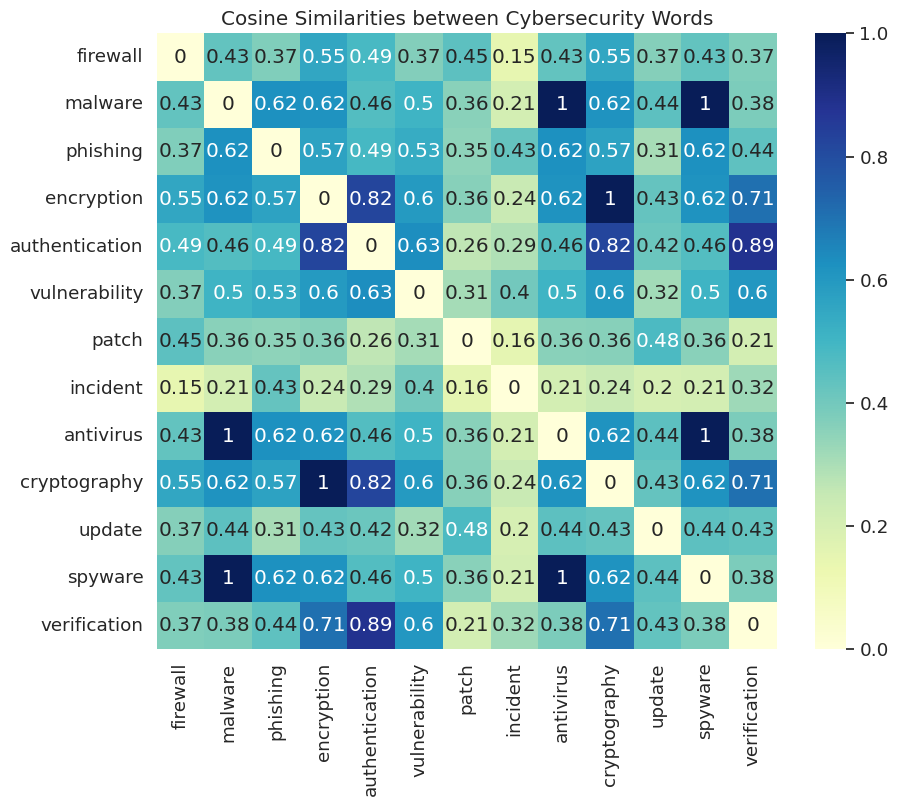

In [34]:
# Calculate cosine similarities arrays for plotting
similarities = calculate_cosine_similarity(word_embeddings, 0)

# Plot the heatmap
sns.set(font_scale=1.2)
plt.figure(figsize=(10, 8))
sns.heatmap(
    similarities,
    annot=True,
    xticklabels=cybersecurity_words,
    yticklabels=cybersecurity_words,
    cmap="YlGnBu",
)
plt.title("Cosine Similarities between Cybersecurity Words")
plt.show()